# An Easy and Useful Guide to Batch Gradient Descent
-------------------------
## What is Batch Gradient Descent?
The question you're probably asking right now is, "what is batch gradient descent and how does it differ from normal gradient descent?" Batch gradient descent splits the training data up into smaller chunks (batches) and performs a forward propagation and backpropagation by the batch. This allows us to update our weights multiple times in a single epoch.

## What Are the Benefits?
Performing calculations on small batches of the data, rather than all our data at once, is beneficial in a few ways. To name a few:

1. It's less straining on memory. Think about if we had a million 4K images . Always holding a million 4K images in memory is extremely taxing.
2. Because we're performing multiple weight updates in a single epoch, we're able to converge (get to the bottom of our hill) in less epochs.
3. Splitting up our data into batches makes it so that our model is only looking at a random sample of our data at every iteration. This allows it to generalize better. Better generalization = less chance of overfitting.

## Why Does It Work?
One of the questions I had when I first came across batch gradient descent was, "we're asked to gather as much data as we can only to break that data up into small chunks? I don't get it… "

I'm going to go over an example (with code) to show why breaking our data into smaller chunks actually works.

Before I show the example, we're going to have to import a few libraries.

In [ ]:
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import random
from IPython import display
import time

Now that we've imported our libraries, using sklearn, we're going to make an example dataset. It's going to be a regression line made up of 1000 points.

In [ ]:
X, y = make_regression(n_samples=1000, n_features=1, bias=5, noise=10, random_state=762)
y = y.reshape(-1, 1)

Let's look at our example dataset by using matplotlib to plot it.


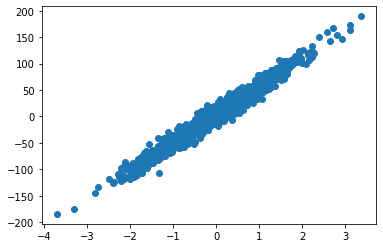

In [ ]:
plt.scatter(X, y)
plt.show()

Cool. It looks exactly as we expected. 1000 points and a regression line.

Now, something I want to show is that when we take a random sample of 64 points (i.e., our batch size), our random sample is a good representation of our full dataset.

To see this in action, let's plot 10 different sets each containing 64 different random samples.

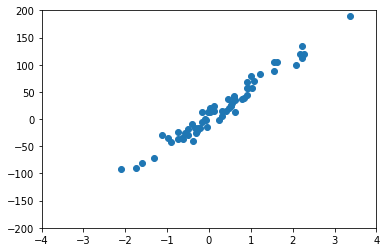

In [ ]:
for i in range(10):
  display.display(plt.gcf())
  display.clear_output(wait=True)

  rand_indices = random.sample(range(1000), k=64)
  plt.xlim(-4,4)
  plt.ylim(-200,200)
  
  plt.scatter(X[rand_indices], y[rand_indices])
  plt.show()
  time.sleep(0.5)

I hope it's making sense. Although we're only plotting 64 random points, those 64 points give us a very good understanding of the shape and direction of the 1000 points. The argument batch gradient descent makes is that given a good representation of a problem (this good representation is assumed to be present when we have a lot of data), a small random batch (e.g., 64 data points) is sufficient to generalize our larger dataset.

## Implementing Batch Gradient Descent
Now that we've gone over the what and the why, let's go over the how. We'll end this article off with how to implement batch gradient descent in code.

Let's start off by importing a few useful libraries.

In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn as nn

Next, let's import our dataset and do a little bit of preprocessing on it. The dataset we'll be working with is the Pima Indians Diabetes dataset. We'll import it, split it into a train and test set and then standardize both the train and the test sets, while converting them into PyTorch tensors.

In [2]:
df = pd.read_csv(r'https://raw.githubusercontent.com/a-coders-guide-to-ai/a-coders-guide-to-neural-networks/master/data/diabetes.csv')

X = df[df.columns[:-1]]
y = df['Outcome']
X = X.values
y = torch.tensor(y.values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = torch.tensor(scaler.transform(X_train))
X_test = torch.tensor(scaler.transform(X_test))

Now, we're going to need our neural network. We'll build a single layer feed forward neural network, consisting of 4 nodes in its hidden layer.

In [ ]:
class Model(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.hidden_linear = nn.Linear(8, 4)
        self.output_linear = nn.Linear(4, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, X):
        hidden_output = self.sigmoid(self.hidden_linear(X))
        output = self.sigmoid(self.output_linear(hidden_output))
        return output

Let's create a function to show accuracy as a metric (our loss is BCE). I like doing this because BCE isn't really human readable, but accuracy is very human friendly. We'll also setup a few variables to reuse.

In [ ]:
def accuracy(y_pred, y):
    return torch.sum((((y_pred>=0.5)+0).reshape(1,-1)==y)+0).item()/y.shape[0]

epochs = 1000+1
print_epoch = 100
lr = 1e-2

Our print_epoch variable just tells our code how often we want to see our metrics (i.e., BCE and accuracy).

Let's instantiate our Model class and set our loss (BCE) and optimizer.

In [ ]:
model = Model()
BCE = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

Awesome, we can finally train our model. Let's first do it without batch gradient descent and then with. It'll help us compare.

In [ ]:
train_loss = []
test_loss = []

for epoch in range(epochs):
    model.train()
    y_pred = model(X_train.float())
    loss = BCE(y_pred, y_train.reshape(-1,1).float())
    train_loss.append(loss)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if(epoch % print_epoch == 0):
        print('Train: epoch: {0} - loss: {1:.5f}; acc: {2:.3f}'.format(epoch, train_loss[-1], accuracy(y_pred, y_train)))
        
    model.eval()
    y_pred = model(X_test.float())
    loss = BCE(y_pred, y_test.reshape(-1,1).float())
    test_loss.append(loss)
    
    if(epoch % print_epoch == 0):
        print('Test: epoch: {0} - loss: {1:.5f}; acc: {2:.3f}'.format(epoch, test_loss[-1], accuracy(y_pred, y_test)))

Train: epoch: 0 - loss: 0.70378; acc: 0.438
Test: epoch: 0 - loss: 0.70231; acc: 0.425
Train: epoch: 100 - loss: 0.67698; acc: 0.640
Test: epoch: 100 - loss: 0.67343; acc: 0.654
Train: epoch: 200 - loss: 0.66399; acc: 0.646
Test: epoch: 200 - loss: 0.65932; acc: 0.661
Train: epoch: 300 - loss: 0.65624; acc: 0.646
Test: epoch: 300 - loss: 0.65105; acc: 0.661
Train: epoch: 400 - loss: 0.65050; acc: 0.646
Test: epoch: 400 - loss: 0.64519; acc: 0.661
Train: epoch: 500 - loss: 0.64554; acc: 0.646
Test: epoch: 500 - loss: 0.64035; acc: 0.661
Train: epoch: 600 - loss: 0.64084; acc: 0.646
Test: epoch: 600 - loss: 0.63593; acc: 0.661
Train: epoch: 700 - loss: 0.63617; acc: 0.646
Test: epoch: 700 - loss: 0.63165; acc: 0.661
Train: epoch: 800 - loss: 0.63141; acc: 0.646
Test: epoch: 800 - loss: 0.62739; acc: 0.661
Train: epoch: 900 - loss: 0.62650; acc: 0.646
Test: epoch: 900 - loss: 0.62304; acc: 0.661
Train: epoch: 1000 - loss: 0.62141; acc: 0.646
Test: epoch: 1000 - loss: 0.61859; acc: 0.661


As expected, the results aren't great. 1000 epochs isn't that much for such a complex dataset, when not using batch gradient descent.

Let's rerun it, except this time, with batch gradient descent. We'll reinstantiate our Model class and reset our loss (BCE) and optimizer. We'll also set our batch size to 64.

In [ ]:
model = Model()
BCE = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr)
batch_size = 64

Great. Now that we have that done, let's run it and see the difference.

In [ ]:
train_loss = []
test_loss = []

for epoch in range(epochs):
    model.train()
    for i in range(0, len(X_train), batch_size):
      if(i+batch_size > len(X_train)-1):
        train_loss.append(loss)
        if(epoch % print_epoch == 0):
          print('Train: epoch: {0} - loss: {1:.5f}; acc: {2:.3f}'.format(epoch, train_loss[-1], accuracy(y_pred, y_train[beg:end])))

        end = -1
      else:
        end = i+batch_size

      beg = i

      y_pred = model(X_train[beg:end].float())
      loss = BCE(y_pred, y_train[beg:end].reshape(-1,1).float())     
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
        

    model.eval()
    y_pred = model(X_test.float())
    loss = BCE(y_pred, y_test.reshape(-1,1).float())
    test_loss.append(loss)
    
    if(epoch % print_epoch == 0):
        print('Test: epoch: {0} - loss: {1:.5f}; acc: {2:.3f}'.format(epoch, test_loss[-1], accuracy(y_pred, y_test)))


Train: epoch: 0 - loss: 0.67945; acc: 0.672
Test: epoch: 0 - loss: 0.68173; acc: 0.630
Train: epoch: 100 - loss: 0.59933; acc: 0.688
Test: epoch: 100 - loss: 0.59577; acc: 0.713
Train: epoch: 200 - loss: 0.53685; acc: 0.766
Test: epoch: 200 - loss: 0.54513; acc: 0.764
Train: epoch: 300 - loss: 0.49951; acc: 0.781
Test: epoch: 300 - loss: 0.52110; acc: 0.740
Train: epoch: 400 - loss: 0.48326; acc: 0.781
Test: epoch: 400 - loss: 0.51550; acc: 0.736
Train: epoch: 500 - loss: 0.47704; acc: 0.781
Test: epoch: 500 - loss: 0.51673; acc: 0.736
Train: epoch: 600 - loss: 0.47478; acc: 0.781
Test: epoch: 600 - loss: 0.51948; acc: 0.740
Train: epoch: 700 - loss: 0.47386; acc: 0.781
Test: epoch: 700 - loss: 0.52198; acc: 0.736
Train: epoch: 800 - loss: 0.47327; acc: 0.797
Test: epoch: 800 - loss: 0.52378; acc: 0.744
Train: epoch: 900 - loss: 0.47261; acc: 0.797
Test: epoch: 900 - loss: 0.52489; acc: 0.744
Train: epoch: 1000 - loss: 0.47176; acc: 0.797
Test: epoch: 1000 - loss: 0.52541; acc: 0.744


Interesting. Before we get into the results, you'll see that the code is similar, but I have an extra for loop. This loop is what allows us to iterate through our data, splitting it into batches of size 64.

In terms of the result, you'll see that it significantly outperforms training our model without batch gradient descent. In the same amount of epochs, our model jumped from 66% accuracy on the test set to 74% and our BCE went from 0.62 to 0.53.